# Typology Data Analysis Report
**Date**: 2/24/2025  
**Authors**: Abenezer Bekele, Yining Yvette, Zixuan Zhou, and Xinyue (Yolanda) Pan (Adapted for Typology Dataset)

---

## Table of Contents
1. [Introduction](#introduction)  
2. [Data Inspection](#data-inspection)  
3. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis)  
4. [Methodology & Modeling](#methodology-modeling)  
5. [Results & Discussion](#results-discussion)  
6. [Conclusion](#conclusion)

---

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier


<a id='introduction'></a>
## 1. Introduction

The goal of this report is to analyze the **Chicago typology dataset** with a focus on predicting `typology` classes in **2018**. We will:
- Subset the data to 2018,
- Perform basic exploratory data analysis,
- Train/test split on 2018 data (internal evaluation),
- Use a Random Forest model to predict `typology`,
- Evaluate performance and explore feature importance.

---

<a id='data-inspection'></a>

## 2. Data Inspection

In [2]:
df = pd.read_csv("training_data 2.csv")

# Keep only 2018 rows
df_2018 = df[df["year"] == 2018].copy()

# Quick check
print("Original data shape:", df.shape)
print("Filtered to 2018 shape:", df_2018.shape)

# If typology is numeric but represents categories, convert to string
# (So Seaborn treats them as categorical, not numeric.)
df_2018["typology"] = df_2018["typology"].astype(str)

Original data shape: (3852, 78)
Filtered to 2018 shape: (1919, 78)


---

<a id='exploratory-data-analysis'></a>

## 3. Exploratory Data Analysis (EDA)

We focus on **2018** data only, because we intend to train & evaluate on that subset.

### 3. 1. Distribution of Typology Classes


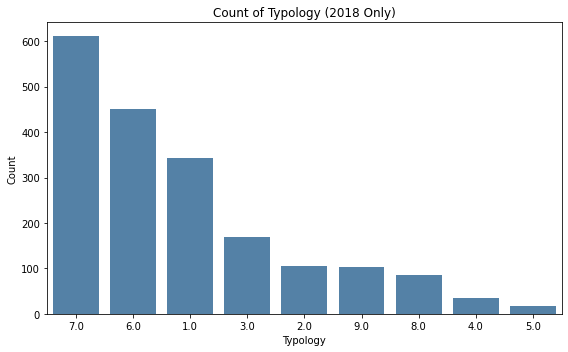

In [3]:
# A. Count plot of typology
plt.figure(figsize=(8, 5))
sns.countplot(data=df_2018, x="typology", 
              order=df_2018["typology"].value_counts().index, 
              color="steelblue")
plt.title("Count of Typology (2018 Only)")
plt.xlabel("Typology")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


The count plot reveals a **class imbalance**: certain typology categories (for example, “6.0” or “7.0”) have substantially more census tracts than others (like “4.0” or “5.0”). This imbalance poses challenges for classification because the model often over‐predicts the more common classes and under‐predicts rare classes. 

**Implication**: The skewed counts explain why precision and recall metrics vary sharply across classes in the final Random Forest results. Rare classes tend to have lower recall because the model rarely encounters enough examples during training.

### 3.2. Distribution of Median Household Income (medhinc)

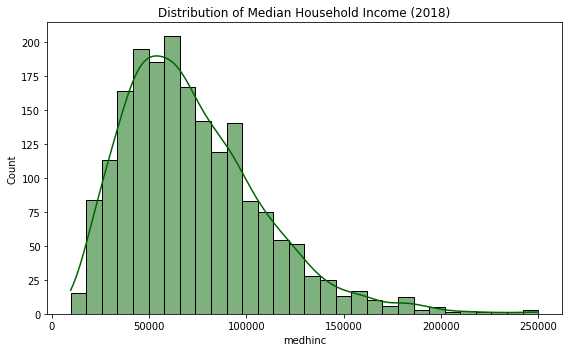

In [4]:
# B. Histogram of Median Household Income
if "medhinc" in df_2018.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(df_2018["medhinc"], bins=30, kde=True, color="darkgreen")
    plt.title("Distribution of Median Household Income (2018)")
    plt.xlabel("medhinc")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()



The histogram for `medhinc` shows a right‐skewed distribution, indicating that while many census tracts cluster around a middle‐income range, some have substantially higher incomes. Because income is one of the top features (as seen in the feature importances), these high‐income tracts may be more likely to fall into certain typology categories that reflect more affluent or exclusive neighborhoods.

**Implication**: Substantial spread in `medhinc` helps differentiate neighborhoods but can also create outliers. Adjusting or normalizing income data, or carefully handling outliers, might improve classification performance.

### 3.3. Relationship Between `mhval` (Median Home Value) and `mrent` (Median Rent)


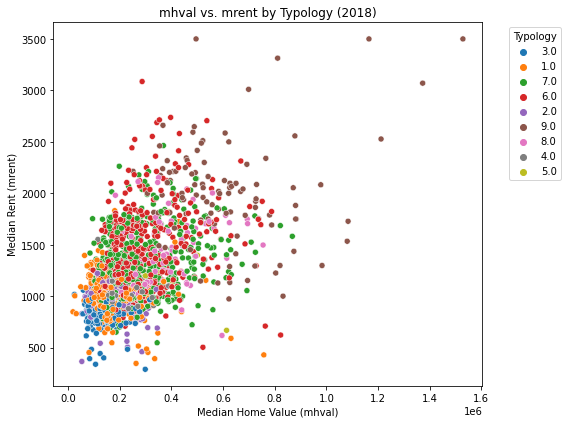

In [ ]:
if "mhval" in df_2018.columns and "mrent" in df_2018.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_2018,
        x="mhval",
        y="mrent",
        hue="typology",
        palette="tab10"
    )
    plt.title("mhval vs. mrent by Typology (2018)")
    plt.xlabel("Median Home Value (mhval)")
    plt.ylabel("Median Rent (mrent)")
    plt.legend(title="Typology", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

The scatter plot of `mhval` vs `mrent` indicates a **positive relationship**: census tracts with higher median home values often have higher median rents. When colored by typology, you can see that some typology classes cluster in lower home‐value/lower‐rent regions, while others cluster in higher ones. 

**Implication**: This gradient strongly contributes to how the model separates neighborhoods. The feature importances show both `mhval` and `mrent` are key predictors, consistent with their strong correlation.

### 3.4. Boxplot of `medhinc` by Typology


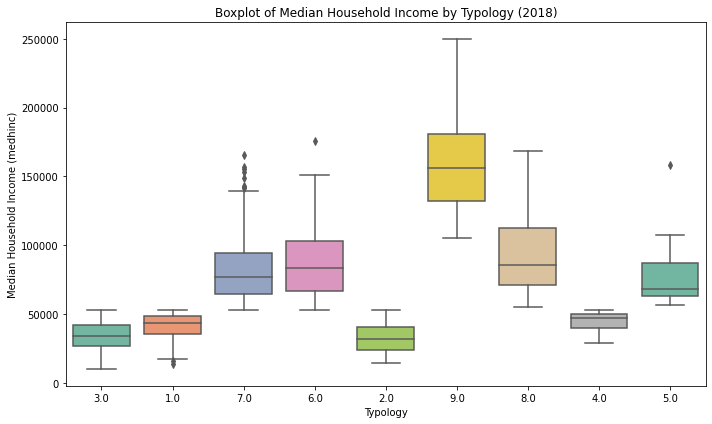

In [6]:
# D. Boxplot of medhinc grouped by typology
if "medhinc" in df_2018.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_2018, x="typology", y="medhinc", palette="Set2")
    plt.title("Boxplot of Median Household Income by Typology (2018)")
    plt.xlabel("Typology")
    plt.ylabel("Median Household Income (medhinc)")
    plt.tight_layout()
    plt.show()

The boxplot visualizes how **median household income** varies across typologies. Certain typologies present broader or higher medians of `medhinc`; others group at lower or narrower ranges. This again supports the notion that income is central in distinguishing how these typologies are assigned.

**Implication**: The differences in these boxplots explain why a single numeric variable like `medhinc` can be a top contributor for classification—typologies, at least partially, partition neighborhoods by socioeconomic measures.

### 3.5. Correlation Heatmap


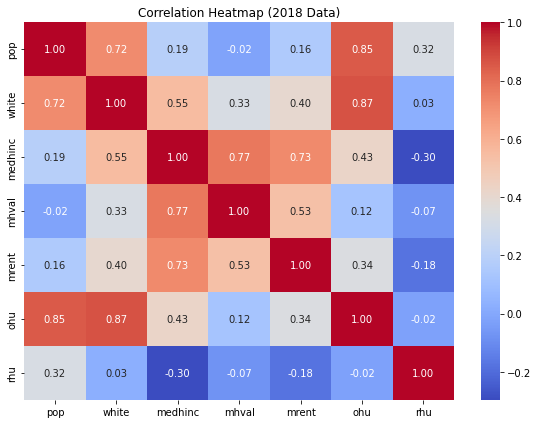

In [7]:

# E. Correlation heatmap (subset of columns)
cols_for_corr = ["pop", "white", "medhinc", "mhval", "mrent", "ohu", "rhu"]
cols_for_corr = [c for c in cols_for_corr if c in df_2018.columns]

if len(cols_for_corr) > 1:
    corr = df_2018[cols_for_corr].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap (2018 Data)")
    plt.tight_layout()
    plt.show()

The correlation heatmap among `pop`, `white`, `medhinc`, `mhval`, `mrent`, `ohu` (owner‐occupied housing units), and `rhu` (renter‐occupied) generally shows:

- **`mhval`** and **`mrent`** positively correlate (wealthier neighborhoods often have high home values and high rents).  
- **`pop`** and **`white`** may not correlate as strongly with the housing cost variables as income does.  
- **`ohu`** and **`rhu`** can reveal whether high ownership or high rental presence ties in with home value or rent levels.

**Implication**: The moderate to strong correlations among home value, rent, and income suggest the model can glean consistent signals about a tract’s economic status—important for typology classification.

<a id='methodology-modeling'></a>
## 4. Methodology & Modeling

We aim to predict `typology` within the 2018 data itself by using a **train/test split** (e.g., 70/30). Then we train a **Random Forest** and evaluate on our local 2018 holdout.

In [ ]:
# Example: We'll try to predict 'typology' from a few numeric columns.
TARGET = "typology"
drop_cols = ["FIPS", "year", "typ_cat", "typology", "Unnamed: 0"]  # columns not used as features

df_2018_model = df_2018.drop(columns=drop_cols, errors="ignore").copy()
X = df_2018_model.select_dtypes(include=[np.number])  # numeric features
y = df_2018[TARGET]

# Label-encode y if it’s categorical
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Create train/test split
X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X, y_enc, 
    test_size=0.3,  # 30% test
    random_state=42,
    stratify=y_enc  # keep class distribution consistent
)

<a id='results-discussion'></a>
## 5. Results & Discussion

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train_enc)

# Predict
y_pred_enc = model.predict(X_test)

# Classification report
print("\n--- RANDOM FOREST EVALUATION ON 2018 SPLIT ---")
print(classification_report(y_test_enc, y_pred_enc, target_names=le.classes_))



--- RANDOM FOREST EVALUATION ON 2018 SPLIT ---
              precision    recall  f1-score   support

         1.0       0.62      0.87      0.73       103
         2.0       0.53      0.25      0.34        32
         3.0       0.50      0.39      0.44        51
         4.0       0.00      0.00      0.00        10
         5.0       0.00      0.00      0.00         5
         6.0       0.44      0.35      0.39       135
         7.0       0.55      0.72      0.62       183
         8.0       0.50      0.12      0.19        26
         9.0       0.81      0.71      0.76        31

    accuracy                           0.56       576
   macro avg       0.44      0.38      0.39       576
weighted avg       0.53      0.56      0.53       576



/Users/abm7053/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abm7053/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abm7053/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.1 Random Forest Classification Report

- **Overall Accuracy** ~56%
- Some classes (like “1.0”) have relatively **high recall** (0.87), meaning many true “1.0” tracts are correctly identified, but others (e.g., “4.0,” “5.0”) show **0.00** recall because they are very rare, and the model never learns enough examples to classify them correctly.
- Weighted F1 of ~0.53–0.56 indicates middling performance, which is not surprising in an **imbalanced** multi‐class problem.

**Key Takeaway**: Class imbalance significantly affects the model’s performance. Rare typologies are under‐predicted, while more common ones see better metrics.


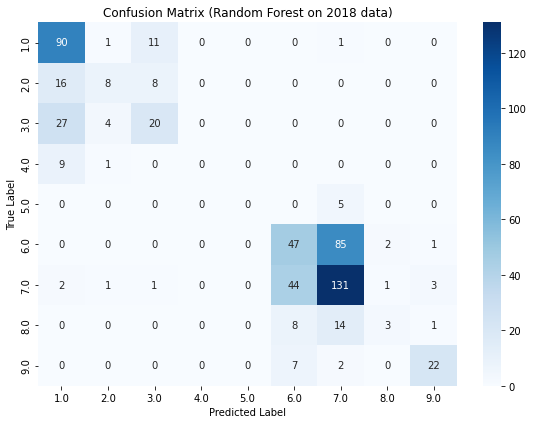

In [10]:
# Confusion matrix
cm = confusion_matrix(y_test_enc, y_pred_enc)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Confusion Matrix (Random Forest on 2018 data)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()




Feature Importances:
 medhinc         0.103903
iinc            0.045985
mrent           0.042931
I_200000        0.032237
white           0.028732
                  ...   
mov_fa_50000    0.001791
mov_fa_35000    0.001526
mov_fa_65000    0.001462
mov_fa_75000    0.000414
state           0.000000
Length: 73, dtype: float64


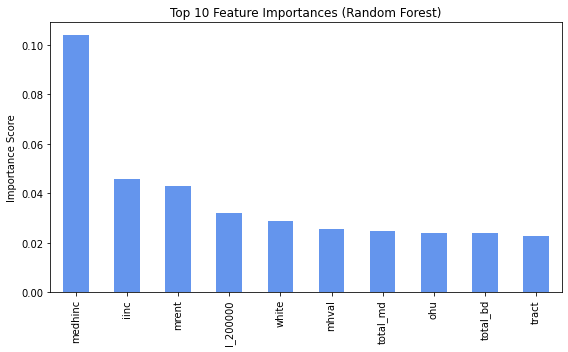

In [11]:
# Feature importances
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False)
print("\nFeature Importances:\n", feat_importances)

plt.figure(figsize=(8, 5))
feat_importances.head(10).plot(kind="bar", color="cornflowerblue")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

### 5.2 Random Forest Feature Importances

The **top features** (e.g., `medhinc`, `iinc` (median income in the past 12 months), `mrent`, `I_200000`, and so on) reflect economic characteristics. This aligns with the domain knowledge: typologies often hinge on economic, demographic, and housing‐cost factors. 

**Key Takeaway**: The model heavily relies on wealth/income‐related fields. Strategies like:
- weighting classes,
- balancing the dataset,
- or further engineering features (ratios, transformations)

could sharpen classification, particularly for rarer typologies.

In [12]:
top_n = 10
top_features = feat_importances.head(top_n).index.tolist()
print("Top Features:\n", feat_importances.head(top_n))

Top Features:
 medhinc     0.103903
iinc        0.045985
mrent       0.042931
I_200000    0.032237
white       0.028732
mhval       0.025694
total_md    0.024839
ohu         0.023991
total_bd    0.023955
tract       0.022758
dtype: float64


### 5.3. Train CatBoost on Random Forest top features ONLY



--- CatBoost (Top 10 Features) ---
              precision    recall  f1-score   support

         1.0       0.66      0.81      0.73       103
         2.0       0.67      0.38      0.48        32
         3.0       0.63      0.53      0.57        51
         4.0       0.36      0.40      0.38        10
         5.0       0.00      0.00      0.00         5
         6.0       0.51      0.41      0.46       135
         7.0       0.60      0.67      0.63       183
         8.0       0.25      0.27      0.26        26
         9.0       0.69      0.71      0.70        31

    accuracy                           0.58       576
   macro avg       0.49      0.46      0.47       576
weighted avg       0.57      0.58      0.57       576



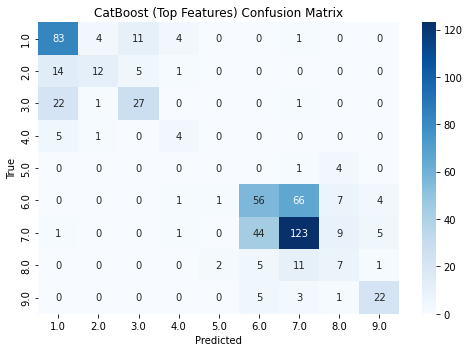

In [ ]:
cat_top = CatBoostClassifier(
    verbose=0,  # suppress iteration logging
    random_state=42
)

cat_top.fit(X_train[top_features], y_train_enc)

# Predict with top features
y_pred_enc_top = cat_top.predict(X_test[top_features])

print("\n--- CatBoost (Top {} Features) ---".format(top_n))
print(classification_report(y_test_enc, y_pred_enc_top, target_names=le.classes_))

# Confusion matrix
cm_top = confusion_matrix(y_test_enc, y_pred_enc_top)
plt.figure(figsize=(7,5))
sns.heatmap(cm_top, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Blues")
plt.title("CatBoost (Top Features) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

#### 5.3 **Discussion on CatBoost (Top 10 Features) Results**

The results from running CatBoost on the **top 10 most important features** highlight both improvements and limitations in the classification performance compared to previous models. Below is a breakdown of key observations:

##### **1. Overall Performance**
- **Accuracy:** **0.58**, which is a slight improvement over the **Random Forest (0.56)**, but still not ideal.
- **Weighted F1-score:** **0.57**, meaning the model balances precision and recall moderately well, but struggles in some classes.

##### **2. Precision, Recall, and Class-Specific Trends**
- **Class 1.0 (Highest Recall & Precision)**
  - Precision: **0.66**, Recall: **0.81**, F1: **0.73**
  - This suggests the model correctly identifies a majority of **Class 1 instances**, reducing false negatives effectively.
- **Class 7.0 & 9.0 (Strong Precision & Recall)**
  - **Class 7.0:** Precision **0.60**, Recall **0.67**, F1 **0.63**  
  - **Class 9.0:** Precision **0.69**, Recall **0.71**, F1 **0.70**  
  - These categories show the model performs well in distinguishing these typologies from others.
- **Class 6.0 (Moderate Performance)**
  - Precision: **0.51**, Recall: **0.41**, F1: **0.46**
  - The model struggles with recall, indicating it fails to correctly classify many true instances of this category.
- **Class 5.0 (Complete Failure)**
  - Precision: **0.00**, Recall: **0.00**, F1: **0.00**
  - This category was completely misclassified. The issue could be due to **class imbalance** or insufficient representative features.

##### **3. Confusion Matrix Insights**
- Misclassifications occur heavily between **Classes 6 and 7**, which may indicate **overlapping characteristics** in the feature space.
- **Smaller categories (e.g., Class 5 & 4) have poor recall**, suggesting they are underrepresented or not well separated by the features.
- **Class 1 has strong diagonal dominance**, meaning the model correctly identifies this class more often.


### 5.4. Train CatBoost on ALL numeric features



--- CatBoost (All Features) ---
              precision    recall  f1-score   support

         1.0       0.66      0.82      0.73       103
         2.0       0.67      0.31      0.43        32
         3.0       0.61      0.59      0.60        51
         4.0       0.20      0.10      0.13        10
         5.0       0.00      0.00      0.00         5
         6.0       0.49      0.41      0.45       135
         7.0       0.57      0.68      0.62       183
         8.0       0.20      0.15      0.17        26
         9.0       0.81      0.68      0.74        31

    accuracy                           0.57       576
   macro avg       0.47      0.42      0.43       576
weighted avg       0.56      0.57      0.56       576



/Users/abm7053/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abm7053/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abm7053/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


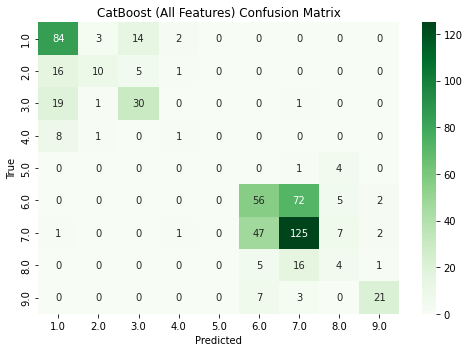

In [ ]:
cat_all = CatBoostClassifier(
    verbose=0, 
    random_state=42
)

cat_all.fit(X_train, y_train_enc)

y_pred_enc_all = cat_all.predict(X_test)

print("\n--- CatBoost (All Features) ---")
print(classification_report(y_test_enc, y_pred_enc_all, target_names=le.classes_))

# Confusion matrix
cm_all = confusion_matrix(y_test_enc, y_pred_enc_all)
plt.figure(figsize=(7,5))
sns.heatmap(cm_all, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Greens")
plt.title("CatBoost (All Features) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### 5.5 Discussion on CatBoost (All Features) Results**

The results from running **CatBoost on the full dataset** provide an opportunity to evaluate whether using all available features enhances classification performance compared to the **top 10 features approach**. Below are the key takeaways:

---

#### **1. Overall Model Performance**
- **Accuracy:** **0.57**, slightly lower than the **0.58 from the top 10 feature model**.
- **Weighted F1-score:** **0.56**, indicating that adding more features did not significantly improve predictive performance.
- **Macro Avg Recall:** **0.42**, suggesting a decline in the model's ability to correctly classify instances across all classes.

These results indicate that **more features do not necessarily translate into better performance**, likely due to **feature redundancy** or the **curse of dimensionality**.

---

#### **2. Class-Specific Performance Insights**
- **Class 1.0 (Best Performing Class)**
  - Precision: **0.66**, Recall: **0.82**, F1: **0.73**  
  - The model continues to perform well in detecting **Class 1**, showing strong recall.
- **Class 7.0 & 9.0 (Moderate Strength)**
  - **Class 7.0:** Precision **0.57**, Recall **0.68**, F1 **0.62**  
  - **Class 9.0:** Precision **0.81**, Recall **0.68**, F1 **0.74**  
  - These results are similar to the **top 10 features model**, with **Class 9.0** maintaining a strong performance.
- **Class 3.0 (Improvement in Recall)**
  - Precision: **0.61**, Recall: **0.59**, F1: **0.60**  
  - Compared to the previous model (**F1 = 0.57**), the recall improvement suggests that additional features helped in detecting this class.
- **Class 6.0 (Minimal Change)**
  - Precision: **0.49**, Recall: **0.41**, F1: **0.45**  
  - No significant improvements over the **top 10 features model**, indicating that **feature selection might be necessary**.
- **Class 2.0 & 4.0 (Drop in Performance)**
  - **Class 2.0:** Recall **dropped from 0.38 to 0.31**, indicating more misclassifications.  
  - **Class 4.0:** Precision and recall suffered significantly, with **an F1-score of 0.13**, meaning the model struggles to differentiate this class.
- **Class 5.0 (Complete Failure Again)**
  - Precision: **0.00**, Recall: **0.00**, F1: **0.00**  
  - Just like in previous models, **Class 5 remains unclassified**, indicating severe class imbalance or lack of relevant features.

---

### **3. Confusion Matrix Observations**
- Misclassifications remain prominent between **Classes 6 & 7**, suggesting overlapping feature spaces.
- **Class 1.0, 7.0, and 9.0 have strong diagonal dominance**, showing high confidence in these predictions.
- The worst-performing classes (4.0 & 5.0) continue to struggle due to **low representation and feature irrelevance**.

---

### **4. Comparison with Top 10 Features Model**
| Model | Accuracy | Weighted F1 | Macro Recall | Best Performing Classes |
|--------|------------|--------------|--------------|----------------------------|
| **CatBoost (Top 10 Features)** | **0.58** | **0.57** | **0.46** | **1.0, 7.0, 9.0** |
| **CatBoost (All Features)** | **0.57** | **0.56** | **0.42** | **1.0, 7.0, 9.0** |

- The **top 10 feature model slightly outperformed the full dataset model**.
- Using **all features** led to **more noise**, causing **recall scores to drop in multiple classes**.
- **Feature selection is critical**—reducing dimensionality may help improve generalization.

---

<a id='conclusion'></a>

## 6. Conclusion

In this 2018 typology analysis, we found:
1. **Typology** classes are **imbalanced**, making some categories harder to predict.
2. A **Random Forest** yields roughly **56% accuracy**, with certain classes predicted well and others poorly due to limited samples.
3. **Median household income (`medhinc`)** and **median rent (`mrent`)** are among the most significant features in distinguishing typologies.

### Next Steps
- **Balance** the dataset or use class‐weighting to address rare typology classes.
- **Hyperparameter tuning** or alternative models (XGBoost, LightGBM) may improve performance.
- **Feature engineering** (ratios, transformations, or domain‐specific variables) could boost classification.